In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import constants 
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import pandas as pd
import seaborn as sns
import itertools
from compute_alpha_hour import compute_alpha_hour
from fit_spline import df_to_spline



In [2]:
# Load weather data 

# specify the file path (use the actual path on your system)
file_path = 'Meteo_data/Weather_data_2023_7_8_n1.csv'

# read the CSV file into a DataFrame
df = pd.read_csv(file_path) #Data in seconds, T in K and P in Pa, windspeed in m/s, 0.1 meter above the ground

# Set time period
n_days = int(file_path[-5]) #Extract how many days are simulated in the file
df

,t,T_amb,P_amb,v_wind,P_sun
0,0.0,292.200000,101790.000000,1.141151,0.0
1,1.0,292.199833,101789.988889,1.141151,0.0
2,2.0,292.199667,101789.977778,1.141151,0.0
3,3.0,292.199500,101789.966667,1.141151,0.0
4,4.0,292.199333,101789.955556,1.141151,0.0
...,...,...,...,...,...
86396,86396.0,296.400000,101710.000000,1.033567,0.0
86397,86397.0,296.400000,101710.000000,1.033567,0.0
86398,86398.0,296.400000,101710.000000,1.033567,0.0
86399,86399.0,296.400000,101710.000000,1.033567,0.0


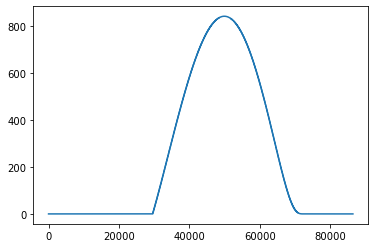

In [3]:
from scipy.interpolate import UnivariateSpline
smoothing_factor=1
t=range(len(df['t']))
T_amb_spline = UnivariateSpline(df['t'], df['T_amb'], s=smoothing_factor)
P_amb_spline = UnivariateSpline(df['t'], df['P_amb'], s=smoothing_factor)
P_sun_spline = UnivariateSpline(df['t'], df['P_sun'], s=smoothing_factor)
plt.plot(t,P_sun_spline(t))


Simulation variables

In [4]:
#Vessel variables
#rho_vessel = 2.7e3 # aluminium [kg/m3]
rho_vessel = 1.455e3 # Pet [kg/m3] Source: https://plasticranger.com/density-of-pet-plastic/#:~:text=The%20density%20of%20PET%20plastic%20is%201.38%20g%2Fcm%C2%B3%20and,(1.2%20g%2Fcm3).
t_vessel = 0.5e-3 # Thickness [m]
#c_vessel = 890 #J/kg aluminium
c_vessel = 1030 #J/kg Pet Source: https://www.engineeringtoolbox.com/specific-heat-polymers-d_1862.html

#Assumptions
A_factor=0.5 #Assume half of the area of the vessel is exposed to sunlight 
e = 0.9 # emissvity factor black epoxy
alpha=100#[W/M^2K] Convection heat transfer coeficient
P_crit=1e3 #[pa] critical pressure where the hysterical valve opens
cloud_factor = np.linspace(0.1,1,2) # 1 = sunny, 0 = dark 




Simulation constants

In [5]:
#Vessel properties 
D = np.linspace(0.05,0.3,2) #Diameter vessel
L = np.linspace(0.05,0.3,2) #Lenght vessel

# Create a 2-D grid for D and L
D, L = np.meshgrid(D, L)

# Now D and L are 2-D arrays containing all combinations of diameter and length
V = D**2/4*np.pi*L  # [m^3]
A = D*L + D**2/4*np.pi  # [m^2]

#Air 
rho_air=1.293 #kgm-3 
m_air = rho_air*V #[kg]
R = constants.R #J/K*molz ideal gas constant 
c_air = 718 #j/kg K constant volume
n_mass = 28.96747 #molar mass [g/mol]
n = m_air/n_mass #Amount of mol air 
sigma = constants.sigma #Boltzman constant 

cp = 1000 #J/kgK @ 300 K
cv = 718 #J/kgK @ 300k
y = cp/cv 
K = 273.15 #Kelvin 

#Combined properties
m_vessel = A*t_vessel*rho_vessel
m = m_vessel+m_air #kg
c = m_vessel/m*c_vessel+m_air/m*c_air #j/kg K 

# Find the dimensions of A_exposed
num_rows, num_cols = A.shape
A_exposed= A_factor*A

# Create an array for each hour in the day, converted to seconds
dt=1 # Second
day_length = n_days*24 * 60 * 60  # length of a day in seconds
time_steps = np.linspace(0, day_length, num=day_length // dt + n_days)  # time steps
hours = np.arange(n_days*24)*60*60


Heat transfer coefficient alpha as function of windspeed and cilinder diameter

In [6]:
#Interpolate the hourly wind data to convection per second
alpha_hour = compute_alpha_hour(num_rows, num_cols, D, df['v_wind'], time_steps, hours)

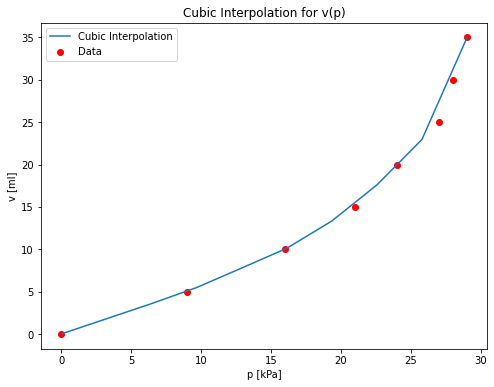

5.714285714285714


In [7]:
# Fit PV curve

# Data from Shibo groupmeeting slides pneunet actuator with h = \inf 
v_fit = np.array([0, 5, 10, 15, 20, 25, 30, 35])*1e-6 #[m3] data in mL converted to L
p_fit = np.array([0, 9, 16, 21, 24, 27, 28, 29])*1000 #[pa] data in kpa converted to pa

# Create cubic spline
volume_act = interp1d(p_fit, v_fit, kind='slinear',bounds_error=False, fill_value="extrapolate") #L/Pa

# Plot
p_vals = np.linspace(p_fit[0], p_fit[-1], 10)
v_vals = volume_act(p_vals)

plt.figure(figsize=(8, 6))
plt.plot(p_vals/1000, v_vals*1e6, label='Cubic Interpolation')
plt.scatter(p_fit/1000, v_fit*1e6, color='red', label='Data')
plt.legend()
plt.xlabel('p [kPa]')
plt.ylabel('v [ml]')
plt.title('Cubic Interpolation for v(p)')
plt.show()

p = 10e3  # For example
v = volume_act(p)
print(v*1e6)

Define system of ODE's

In [43]:
def system(t, y, params):
    T, P, n_mol = y
    P_open,P_close,P_amb, solar_constants,R_in,R_valve,R_act, A_Exposed, cloud_factor, T_amb,R, m, c, ii, jj, ff = params
    
    #Make the state of the valve a global variable
    global state_v

    P_sun = P_sun_spline(t) * A_Exposed[ii, jj] * cloud_factor[ff] *dt
    interpolated_P_amb = P_amb_spline(t)    
    interpolated_T_amb = T_amb_spline(t)
    Q_rad = e * sigma * A_exposed[ii,jj] * (T**4 - interpolated_T_amb**4)
    
    #Interpolate alpha from hours to seconds
    alpha_interpolated_func = interp1d(np.arange(len(T_amb)), alpha_hour[ii,jj,:], bounds_error=False, fill_value="extrapolate")
    interpolated_alpha = alpha_interpolated_func(t)
    Q_con = interpolated_alpha * A_exposed[ii,jj] * (T - interpolated_T_amb)

    
    #Valve is normally closed
    dT_dt = (P_sun-Q_rad-Q_con) / (m[ii, jj] * c[ii, jj])
    dP_dt = (n_mol*R*dT_dt)/V[ii,jj]
    #dP_act_dt = 0
    dn_dt = 0
 
    #State 0: inlet and valve are closed
    if state_v == 0:
        if (P > (interpolated_P_amb+P_open)):
            #Change state to open
            state_v = 1

            #Compute flow 
            Q_tank = -(P - interpolated_P_amb) / R_valve #if P > interpolated_P_amb else 0 
            #Q_act = (P_act - interpolated_P_amb) / R_act

            # Pressure drop is related to the volume out and the original volume 
            dP_dt += Q_tank / V[ii,jj]  # Change in pressure in tank
            #dP_act_dt += ((Q_tank - Q_act) / volume_act(P_act-interpolated_P_amb))*P_act
            dn_dt += (V[ii,jj]/T)*(dP_dt/R-P*dT_dt/T)
            print('valve opens, t=', t)
      
            return [dT_dt, dP_dt,dn_dt]
        
        elif (P < (interpolated_P_amb-P_in)):
            # If inlet is open, change state to 2
            state_v=2
            P = interpolated_P_amb
            dn_dt += (V[ii,jj]/T)*(dP_dt/R-P*dT_dt/T)
            print('inlet is open')
            return [dT_dt, dP_dt,dn_dt]

        else:
            print('else')    
            #No events happen
            return [dT_dt, dP_dt,dn_dt]
               
    #State 1: Valve to actuator is open 
    if state_v ==1:
        if P < (interpolated_P_amb + P_close):
            #If pressure drops below closing pressure change state to closed
            state_v = 0
            print('Valve closes')
            
            return [dT_dt, dP_dt,dn_dt]
        else: 
        #Compute pressure changes 
            Q_tank = -(P - interpolated_P_amb) / R_valve #if P > interpolated_P_amb else 0 
            #Q_act = (P_act - interpolated_P_amb) / R_act

            # Pressure drop is related to the volume out and the original volume 
            dP_dt += Q_tank / V[ii,jj]  # Change in pressure in tank
            #dP_act_dt += ((Q_tank - Q_act) / volume_act(P_act-interpolated_P_amb))*P_act
            dn_dt += (V[ii,jj]/T)*(dP_dt/R-P*dT_dt/T)
            print('valve stayed open')
            return [dT_dt, dP_dt,dn_dt]          
              
        

    # state2: inlet is open
    if state_v ==2:
        
        if P > 0.999*interpolated_P_amb:
            #Inlet closes again 
            state_v=0
            print('inlet closed')
            return [dT_dt, dP_dt,dn_dt]
        else:
            # Otherwise it syats open
            Q_tank = (P - interpolated_P_amb) / R_in 

            # Pressure drop is related to the volume out and the original volume 
            dP_dt -= Q_tank / V[ii,jj] 
                
            #P = interpolated_P_amb
            dn_dt += (V[ii,jj]/T)*(dP_dt/R-P*dT_dt/T)
            print('inlet is open')
            return [dT_dt, dP_dt,dn_dt]
    else:
        print('else2')
        return [dT_dt, dP_dt,dn_dt] 


#Define simulation settings
t_span = [0, len(df['P_sun'].values)]  # start and end time

#Set limit pressures where valves open 
P_open = 2e3 #pa 
P_close = 1e3 #pa
P_in = 0.3e3 #pa

R_valve=5000#1/12 # Resistance of first valve, Pa.s/m^3
R_in = 5000#1/12
R_act = 5000
state_v = 0 #Valve starts normally closed
params_base = [P_open,P_close,df['P_amb'].values,df['P_sun'].values, R_in,R_valve,R_act,A_exposed, cloud_factor,df['T_amb'].values, R,m, c ]

# Use itertools.product to simplify nested loops

for ii, jj, ff in itertools.product(range(len(D)), range(len(L)), range(len(cloud_factor))):
    #ii=jj=1
    params = params_base + [ii, jj, ff]
    print(ii,jj,ff)
    
    # Define initial conditions
    n0 = df['P_amb'][0]*V[ii,jj]/(R*df['T_amb'][0])
    y0 = [df['T_amb'][0], df['P_amb'][0], df['P_amb'][0], n0]
    
    t_start= t_span[0]
    nsampling = int(100*len(df['P_amb'].values))
    #solutions = []
    #state=[]
    #state.append(0)
        
    print(y0,t_start)
    sol = solve_ivp(system, [t_start, t_span[1]], y0, dense_output=True, args=(params,),method='RK23',
            t_eval=np.linspace(t_start,t_span[1],nsampling) ,rtol=1e-2, atol=1e-3)
    print(sol.message)
    t= sol.t
    y= sol.y   
      
    break

 


0 0 0
[292.2, 101790.0, 101790.0, 0.004113302145481862] 0
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
inlet is open
inlet closed
else
else
else
inlet is open
inlet closed
else
inlet is open
inlet closed
else
else
inlet is open
inlet closed
inlet is open
inlet closed
else
inlet is open
inlet closed
else
valve opens, t= 877.1466949494755
Valve closes
else
else
else
else
else
else
else
valve opens, t= 1100.5032031786661
Valve closes
else
else
else
else
else
else
else
valve opens, t= 1194.90828415419
Valve closes
else
else
else
else
else
else
else
else
inlet is open
inlet closed
else
else
else
inlet is open
inlet closed
else
else
else
else
else
else
else
inlet is open
inlet closed
else
inlet is open
inlet closed
else
valve opens, t= 1866.5693699929866
Valve closes
else
else
else
else
else
else
else
else
inlet is open
inlet closed
else
else
else
inlet is open
inlet closed
else
else
else
else
valve opens, t= 223

KeyboardInterrupt: 

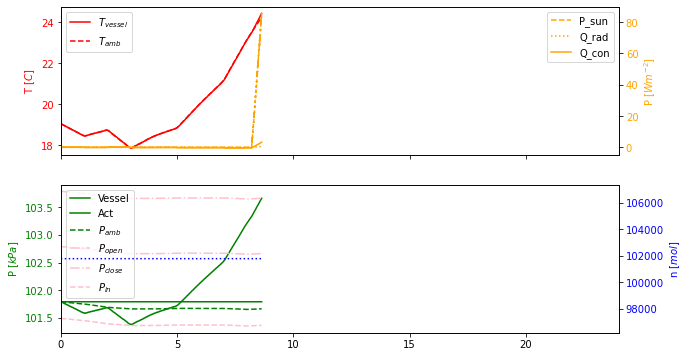

In [ ]:
# Calculate solar constants
#t = np.linspace(0, len(df['P_sun'].values), len(df['P_sun'].values))
solar_constants_func = interp1d(np.arange(len(df['P_sun'].values)), df['P_sun'].values, bounds_error=False, fill_value="extrapolate")
interpolated_solar_constants = solar_constants_func(t)

def interpolate_data(T, t, A_exposed, alpha_hour, T_amb,P_amb, ii, jj):
    # Interpolate T_amb
    #T_amb_func = interp1d(np.arange(len(T_amb)), T_amb, bounds_error=False, fill_value="extrapolate")
    #interpolated_T_amb = T_amb_func(t)
    interpolated_T_amb=T_amb_spline(t)
    

    #P_amb_func = interp1d(np.arange(len(P_amb)), P_amb, bounds_error=False, fill_value="extrapolate")
    #interpolated_P_amb = P_amb_func(t)
    interpolated_P_amb = P_amb_spline(t)
    
    # Interpolate alpha_hour
    alpha_interpolated_func = interp1d(np.arange(len(T_amb)), alpha_hour[ii,jj,:], bounds_error=False, fill_value="extrapolate")
    interpolated_alpha = alpha_interpolated_func(t)
    
    Q_rad = e * sigma * A_exposed[ii,jj] * (T**4 - interpolated_T_amb**4)
    Q_con = interpolated_alpha * A_exposed[ii,jj] * (T - interpolated_T_amb)
    return Q_rad, Q_con, interpolated_P_amb,interpolated_T_amb
#Eval function
y1 = sol.sol(t)

Q_rad, Q_con,P_amb, T_amb = interpolate_data(y1[0,:], t, A_exposed, alpha_hour, df['T_amb'].values,df['P_amb'].values, ii, jj)
#n_mol = y[1,:] * V[ii,jj] / (R * y[0,:]) 
#Plot results 

fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True,figsize=(10,6))  # Create two subplots sharing the same x-axis

# First subplot for temperature and solar constants
ax2 = ax1.twinx()  # Create a second y-axis for the first subplot
ax1.plot(t/3600, y[0,:]-K,color='red',label='$T_{vessel}$') 
ax1.plot(t/3600, T_amb_spline(t)-K,color='red', linestyle='--',label='$T_{amb}$') 
ax1.legend(loc='upper left')
ax1.set_ylabel('T [$C$]',color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2.plot(t/3600, P_sun_spline(t), color='orange',label='P_sun',linestyle='--')
ax2.plot(t/3600, Q_rad/A[ii,jj], label='Q_rad', linestyle=':', color='orange')
ax2.plot(t/3600, Q_con/A[ii,jj], label='Q_con', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylabel('P [$Wm^{-2}$]', color='orange')
ax2.legend()

# Second subplot for pressure and moles
ax4 = ax3.twinx()  # Create a second y-axis for the second subplot
ax3.plot(t/3600, y[1,:]/1000, color='green',label='Vessel') 
ax3.plot(t/3600, y[2,:]/1000, color='green',label='Act') 
ax3.plot(t/3600, P_amb_spline(t)/1000, color='green', linestyle='--',label='$P_{amb}$')
ax3.plot(t/3600, (P_amb+P_open)/1000, color='pink', linestyle='-.',label='$P_{open}$')
ax3.plot(t/3600, (P_amb+P_close)/1000, color='pink', linestyle='-.',label='$P_{close}$')
ax3.plot(t/3600, (P_amb-P_in)/1000, color='pink', linestyle='--',label='$P_{in}$')
ax3.set_ylabel('P [$kPa$]', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.legend(loc='upper left')

ax4.plot(t/3600, y[2,:], color='blue',linestyle=':')  # Plot n_mol on the second y-axis
ax4.set_ylabel('n [$mol$]', color='blue')
ax4.tick_params(axis='y', labelcolor='blue')
#ax4.set_ylim(0,n[ii,jj]*1.1)

#ax5.plot(t/3600, y[3,:], color='blue') #Plot if the valve = open or closed 
#ax5.set_ylim(-0.1,1.1)



#ax5.set_xlabel('Time [$h$]')

plt.xlim(0,24)
plt.show() 

Solve system of ODE's

Plotting

def system(t, y, params):
    T, P, n_mol = y
    P_open,P_close,P_amb, solar_constants,R_valve, A_Exposed, cloud_factor, T_amb,R, m, c,state_v, ii, jj, ff = params

    # Interpolate the solar_constants and T_amb
    solar_constants_func = interp1d(np.arange(len(solar_constants)), solar_constants, bounds_error=False, fill_value="extrapolate")
    interpolated_solar_constants = solar_constants_func(t)
    P_sun = interpolated_solar_constants * A_Exposed[ii, jj] * cloud_factor[ff] *dt

    P_amb_func = interp1d(np.arange(len(P_amb)), P_amb, bounds_error=False, fill_value="extrapolate")
    interpolated_P_amb = P_amb_func(t)

    #Interpolate T_amb and calculate heat loss through radiation, Q_rad
    T_amb_func = interp1d(np.arange(len(T_amb)), T_amb, bounds_error=False, fill_value="extrapolate")
    interpolated_T_amb = T_amb_func(t)
    Q_rad = e * sigma * A_exposed[ii,jj] * (T**4 - interpolated_T_amb**4)
    
    alpha_interpolated_func = interp1d(np.arange(len(T_amb)), alpha_hour[ii,jj,:], bounds_error=False, fill_value="extrapolate")
    interpolated_alpha = alpha_interpolated_func(t)
    Q_con = interpolated_alpha * A_exposed[ii,jj] * (T - interpolated_T_amb)

    
    #Valve is normally closed
    dT_dt = (P_sun-Q_rad-Q_con) / (m[ii, jj] * c[ii, jj])
    dP_dt = (n_mol*R*dT_dt)/V[ii,jj]
    dn_dt = 0


    #State 0: inlet and valve are closed
    if state_v == 0:
        if (P >= (interpolated_P_amb+P_open)):
            #Change state to open
            state_v = 1

            #Compute pressure changes 
            Q_tank = -(P - interpolated_P_amb) / R_valve #if P > interpolated_P_amb else 0 
        
            # Pressure drop is related to the volume out and the original volume 
            dP_dt += Q_tank / V[ii,jj]  # Change in pressure in tank
            dn_dt += (V[ii,jj]/T)*(dP_dt/R-P*dT_dt/T)
            print('valve open, t=', t)
            return [dT_dt, dP_dt,dn_dt]
        
        elif (P < (interpolated_P_amb-P_in)):
            # If inlet is open, change state to 2
            P = interpolated_P_amb
            print('inlet is open')
            return [dT_dt, dP_dt,dn_dt]

        else:    
            #Volume flow out of tank is pressure difference devided by the resistance of the valve 
            Q_tank = -(P - interpolated_P_amb) / R_valve #if P > interpolated_P_amb else 0 
            
            # Pressure drop is related to the volume out and the original volume 
            dP_dt += Q_tank / V[ii,jj]  # Change in pressure in tank
            dn_dt += (V[ii,jj]/T)*(dP_dt/R-P*dT_dt/T)
            print('valve open, t=', t)
            return [dT_dt, dP_dt,dn_dt]
               
    #State 1: Valve to actuator is open 
    if state_v ==1:
        Q_tank = (P - interpolated_P_amb) / R_valve #if P > interpolated_P_amb else 0 

        # Pressure drop is related to the volume out and the original volume 
        dP_dt -= Q_tank / V[ii,jj]  # Change in pressure in tank
        dn_dt += (V[ii,jj]/T)*(dP_dt/R-P*dT_dt/T)
        print('valve stayed open')
        state.append(1)
        if P < (interpolated_P_amb + P_close):
            #If pressure drops below closing pressure change state to closed
            state_v = 0
            print('Valve closes')
            return [dT_dt, dP_dt,dn_dt]


sol = solve_ivp(system, [t_start, t_span[1]], y0, dense_output=True, args=(params,),method='RK45',
    t_eval=np.linspace(t_start,t_span[1],nsampling))

